# A1

In [1]:
# Standard imports
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

### Some solutions (optional)

In [2]:
# RUN THIS CELL ONLY IF YOU WANT TO USE THE SOLUTIONS THROUGHOUT
from a1_solutions import *

In [3]:
# Run this cell if you want to be able to run functions from the solutions, like this...
# lif_a = solutions.LIFNeuron()
import a1_solutions as solutions

## Some supplied helper functions

In [4]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    #levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    labels = [[], []]
    for n in range(N):
        nspikes = len(st[n])
        #y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        lines = plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
        if len(lines) is not 0:
            labels[0].append(lines[0])
            labels[1].append("neur_idx {0}".format(n))
    plt.legend(labels[0], labels[1], loc="upper right")
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the time to end each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


class InputNeuron(object):
    
    def __init__(self, spiketrain):
        '''
        InputNeuron(spiketrain)
        
        Constructor for InputNeuron class.
        
        InputNeuron is a class of neuron that can be used to inject spikes into
        the network. When involved in a simulation, an InputNeuron will generate
        spikes at the times specified during its construction.
        
        Inputs:
         spiketrain is an array or list of spike times
        '''
        self.spikes = np.array(spiketrain)
        self.idx = []  # List index, when added to a network

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = InputNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    def Set_idx(self, idx):
        self.idx = idx
    def Get_idx(self):
        '''
         idx = InputNeuron.Get_idx()
         
         Returns the index of the neuron in its network.
        '''
        return self.idx
    
    def Slope(self):
        return
    
    def Step(self, dt):
        return
    
    def Get_spikes(self):
        return self.spikes

### Example use

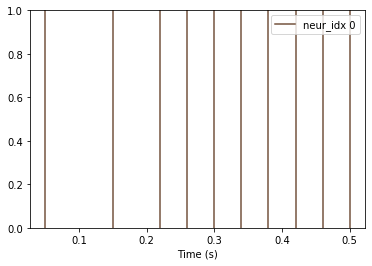

In [5]:
spikes = GenerateSpikeTrain([10, 25], [0.2, 0.5])  # Generates a specified spike train
PlotSpikeRaster([spikes])

In [6]:
neur_in = InputNeuron(spikes)
print(neur_in.Get_spikes())  # Spike times
print(neur_in.SpikesBetween(0.3,0.4)) # Number of spikes between 0.3 and 0.4

[0.05 0.15 0.22 0.26 0.3  0.34 0.38 0.42 0.46 0.5 ]
3


# Q1: Implementing `LIFNeuron` Class

## `LIFNeuron` class

In [7]:
class LIFNeuron(object):

    def __init__(self, Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05):
        '''
        LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
        
        Constructor for LIFNeuron class
        
        Inputs:
         Tau_m   membrane time constant, in seconds (s)
         Tau_ref refractory period (s)
         Tau_s   synaptic time constant (s)
        '''
        self.tau_m = Tau_m      # membrane time constant
        self.tau_ref = Tau_ref  # refractory period
        self.tau_s = Tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        self.t = 0.             # current time
        self.dvdt = 0.          # slope of v (w.r.t. time)
        self.dsdt = 0.          # slope of s (w.r.t. time)
        
        self.idx = []           # List index, when added to a network
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.s_history = []
        self.spikes = []        # list of times when this neuron spiked
        

    # A bunch of set and get functions.
    def Set_v(self, v):
        self.v = v 
    def Get_v(self):
        return self.v
    def Set_s(self, s):
        self.s = s
    def Get_s(self):
        return self.s
    def Set_ref_remaining(self, ref_remaining):
        self.ref_remaining = ref_remaining
    def Get_ref_remaining(self):
        return self.ref_remaining
    def Set_idx(self, idx):
        self.idx = idx
    def Get_idx(self):
        return self.idx
    def Get_spikes(self):
        return self.spikes
    def Set_t(self, t):
        self.t = t
    def Get_v_history(self):
        return self.v_history
    
    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = LIFNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    def Slope(self):
        '''
        LIFNeuron.Slope()
        
        Evaluates the right-hand side of the differential equations that
        govern v and s. The slopes get stored in the internal variables
          self.dvdt, and
          self.dsdt
        '''
        #===== REPLACE THE CODE BELOW =====
        self.dvdt = (self.s-self.v)/self.tau_m
        self.dsdt = -self.s/self.tau_s
        
        
    def Step(self, dt):
        '''
        LIFNeuron.Step(dt)
        
        Updates the LIF neuron state by taking an Euler step in v and s.
        The length of the step is dt seconds.
        If v reaches the threshold of 1, the neuron fires an action potential
        (spike). Linear interpolation should be used to estimate the time that v=1.
        The spike time is appended to the list self.spikes, and v
        is set to zero. After a spike, the neuron is dormant for self.tau_ref
        seconds.
        
        '''
        #==== PLACE YOUR CODE HERE ====
            
        self.s += dt*self.dsdt

        if dt > self.ref_remaining:
            self.t += self.ref_remaining
            dt -= self.ref_remaining
            self.ref_remaining = 0.
            self.v += dt*self.dvdt
            if self.v >= 1:
                spike_time = self.t + dt - (self.v - 1)/self.dvdt
                self.spikes.append(spike_time)
                self.ref_remaining = self.tau_ref - (self.v - 1)/self.dvdt
                self.v = 1
        else:
            self.v = 0
            self.ref_remaining -= dt
        
        self.t += dt
        self.s += self.weighted_incoming_spikes/self.tau_s
        
        # Store v and s (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.s_history.append(self.s)
        self.weighted_incoming_spikes = 0.
        
        
        
    def ReceiveSpike(self, w):
        '''
        LIFNeuron.ReceiveSpike(w)
        
        Registers the arrival of a spike from a presynaptic neuron. The
        member variable self.weighted_incoming_spikes keeps track of all
        the incoming spikes, each weighted by their respective connection
        weights. It is sufficient to add them all together to tabulate the
        total incoming weighted spikes (from all presynaptic neurons).
        
        Input:
         w    is the connection weight from the presynaptic neuron.
        '''
        self.weighted_incoming_spikes += w
        
        
    def ShowState(self):
        '''
         LIFNeuron.ShowState()
         
         Prints the current time, membrane potential, input current, and
         remaining refractory time.
        '''
        print('{0:6.4f}s: s={1:5.3f}, v={2:6.4f}, ref remaining={3:7.5f}'.format(self.t, self.s, self.v, self.ref_remaining))


## Tests

The test below should yield,

    0.0000s: s=0.000, v=0.0000, ref remaining=0.00000
    0.0010s: s=0.600, v=0.0000, ref remaining=0.00000
    0.0020s: s=0.588, v=0.0300, ref remaining=0.00000

In [8]:
lif_a = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)

# If you want to run the version from the supplied solutions, use
# the line below instead.
#lif_a = solutions.LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)

lif_a.ReceiveSpike(0.03)
lif_a.ShowState()
lif_a.Slope()
lif_a.Step(0.001)
lif_a.ShowState()
lif_a.Slope()
lif_a.Step(0.001)
lif_a.ShowState()

0.0000s: s=0.000, v=0.0000, ref remaining=0.00000
0.0010s: s=0.600, v=0.0000, ref remaining=0.00000
0.0020s: s=0.588, v=0.0300, ref remaining=0.00000


================================================================

The test below should yield,

    0.0000s: s=0.500, v=0.0000, ref remaining=0.00150
    0.0010s: s=0.490, v=0.0000, ref remaining=0.00050
    0.0020s: s=0.480, v=0.0123, ref remaining=0.00000

In [9]:
lif_a = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
lif_a.Set_v(0.)
lif_a.Set_s(0.5)
lif_a.Set_ref_remaining(0.0015)
lif_a.ShowState()
lif_a.Slope(); lif_a.Step(0.001)
lif_a.ShowState()
lif_a.Slope(); lif_a.Step(0.001)
lif_a.ShowState()

0.0000s: s=0.500, v=0.0000, ref remaining=0.00150
0.0010s: s=0.490, v=0.0000, ref remaining=0.00050
0.0020s: s=0.480, v=0.0123, ref remaining=0.00000


================================================================

The test below should yield,

    0.3000s: s=1.300, v=0.9800, ref remaining=0.00000
    0.3010s: s=1.274, v=0.9960, ref remaining=0.00000
    0.3020s: s=1.249, v=1.0000, ref remaining=0.00129
    0.3030s: s=1.224, v=0.0000, ref remaining=0.00029
    0.3040s: s=1.199, v=0.0436, ref remaining=0.00000
    Spike occurred at 0.30129 seconds

In [10]:
lif_a = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
lif_a.Set_t(0.3)
lif_a.Set_v(0.98)
lif_a.Set_s(1.3)
dt = 0.001
lif_a.ShowState()
lif_a.Slope(); lif_a.Step(dt); lif_a.ShowState()
lif_a.Slope(); lif_a.Step(dt); lif_a.ShowState()
lif_a.Slope(); lif_a.Step(dt); lif_a.ShowState()
lif_a.Slope(); lif_a.Step(dt); lif_a.ShowState()
if len(lif_a.Get_spikes())>0:
    print('Spike occurred at {0:.5g} seconds'.format(lif_a.Get_spikes()[-1]))

0.3000s: s=1.300, v=0.9800, ref remaining=0.00000
0.3010s: s=1.274, v=0.9960, ref remaining=0.00000
0.3020s: s=1.249, v=1.0000, ref remaining=0.00129
0.3030s: s=1.224, v=0.0000, ref remaining=0.00029
0.3040s: s=1.199, v=0.0436, ref remaining=0.00000
Spike occurred at 0.30129 seconds


================================================================

# Q2: Implementing `SpikingNetwork`

## `SpikingNetwork` Class

In [11]:
class SpikingNetwork(object):
    
    def __init__(self):
        '''
        SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons,
        and the connections between those neurons.
        '''
        self.neurons = []      # List of neurons (of various kinds)
        self.connections = []  # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
        
    def GetNeuron(self, idx):
        '''
         neur = SpikingNetwork.GetNeuron(idx)
         
         Returns the Neuron object at index idx.
        '''
        return self.neurons[idx]
    
    def GetConnection(self, c):
        '''
         con = SpikingNetwork.GetConnection(c)
        '''
        return self.connections[c]
    
    def AddNeuron(self, neur):
        '''
        SpikingNetwork.AddNeuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neurons.append(neur)
        neur.idx = len(self.neurons)-1
        
    def Connect(self, pre, post, w):
        '''
        SpikingNetwork.Connect(pre, post, w)
        
        Connects neuron 'pre' to neuron 'post' with a connection
        weigth of w.
        
        Each "connection" is stored as a list of 3 numbers of the form:
         [ pre_idx, post_idx, weight ]
        where
         pre_idx is the list index of the pre-synaptic neuron,
         post_idx is the list index of the post-synaptic neuron, and
         weight is the connection weight.
        eg. self.connections = [[0,1,0.05], [1,2,0.04], [1,0,-0.2]]
        '''
        self.connections.append([pre, post, w])
        
        
    def Simulate(self, T, dt):
        '''
        SpikingNetwork.Simulate(T, dt)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
        '''
        
        # This code takes care of recording time samples in a way
        # that allows continuation. You needn't fuss over this code.
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        
        #==== HERE IS WHERE YOUR CODE STARTS ====
        
        # Loop over time steps (I've set that up for you)
        for tt in t_segment:
            self.t_history.append(tt)  # Record time stamp
            
            
        #==== PLACE YOUR CODE HERE ====
            for nn in self.neurons:
                nn.Slope()
                nn.Step(dt)
            
            for cc in self.connections:
                pre_s = self.GetNeuron(cc[0])
                post_s = self.GetNeuron(cc[1])
                num_of_pre_s_spikes = pre_s.SpikesBetween(tt, tt+dt)
                post_s.ReceiveSpike(num_of_pre_s_spikes*cc[2])
            
        return


        
    def AllSpikeTimes(self):
        '''
        SpikingNetwork.AllSpikeTimes()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        blah = []
        for neur in self.neurons:
            blah.append(np.array(neur.Get_spikes()))
        return blah

### Test

In [12]:
# This will create a small network to test on. This network is shown in Fig. 1(a).
net = SpikingNetwork()
A = LIFNeuron(Tau_s=0.1)  # Create a LIF neuron
in1 = InputNeuron( GenerateSpikeTrain([30], [1]) )  # Create an input neuron

net.AddNeuron(A)  # Neuron 0 (uses default values for tau_m and tau_ref)
net.AddNeuron(in1)  # Input neuron generates 30 Hz spike train
net.Connect(in1.Get_idx(), A.Get_idx(), 0.05)  # Connection from neuron 1 to neuron 0

net.Simulate(1, 0.001) # Simulate for 1 second

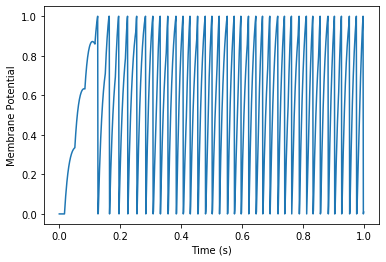

In [13]:
# Plot the membrane potential of net.neuron[0]
plt.plot(net.t_history, net.GetNeuron(0).Get_v_history());
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential');

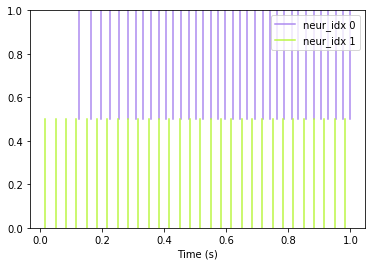

In [14]:
# Plot the spike rasters for all the neurons in the network.
PlotSpikeRaster( net.AllSpikeTimes() )

# Q3: Experiments with Spiking Networks

## (a) LIF Firing Rate Curve

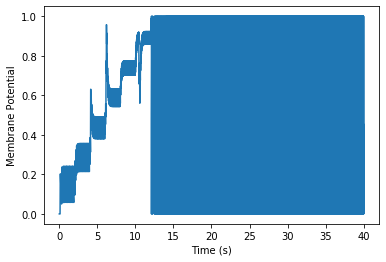

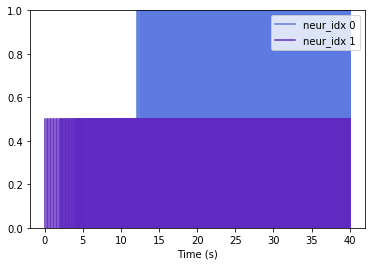

In [15]:
# i.
net = SpikingNetwork()
A = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.1)  # LIF neuron A

Hz_in_list = np.arange(1, 21)*5
s_list = np.arange(1, 21)*2

in1 = InputNeuron( GenerateSpikeTrain(Hz_in_list, s_list) )  # Create an input neuron

net.AddNeuron(A)  # Neuron 0
net.AddNeuron(in1)  # Input neuron generates spike train, Neuron 1
net.Connect(in1.Get_idx(), A.Get_idx(), 0.03)  # Connection from neuron 1 to neuron 0

net.Simulate(s_list[-1], 0.001) # Simulate for 40 second

# Plot the membrane potential of net.neuron[0]
plt.plot(net.t_history, net.GetNeuron(0).Get_v_history());
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential');
plt.show()

# Plot the spike rasters for all the neurons in the network.
PlotSpikeRaster( net.AllSpikeTimes() )
plt.show()

In [16]:
# ii.
Simulated_LIF = net.GetNeuron(A.Get_idx())
t_interval = np.arange(0, 21)*2
Spikes_out_list = []
for idx in range(len(t_interval)-1):
    num_of_spikes = Simulated_LIF.SpikesBetween(t_interval[idx], t_interval[idx+1])
    Spikes_out_list.append(num_of_spikes)
    print('Time Interval {0}s - {1}s: {2} spikes'
          .format(t_interval[idx], t_interval[idx+1], num_of_spikes))
print(Spikes_out_list)

Time Interval 0s - 2s: 0 spikes
Time Interval 2s - 4s: 0 spikes
Time Interval 4s - 6s: 0 spikes
Time Interval 6s - 8s: 0 spikes
Time Interval 8s - 10s: 0 spikes
Time Interval 10s - 12s: 0 spikes
Time Interval 12s - 14s: 30 spikes
Time Interval 14s - 16s: 52 spikes
Time Interval 16s - 18s: 73 spikes
Time Interval 18s - 20s: 87 spikes
Time Interval 20s - 22s: 99 spikes
Time Interval 22s - 24s: 112 spikes
Time Interval 24s - 26s: 125 spikes
Time Interval 26s - 28s: 137 spikes
Time Interval 28s - 30s: 149 spikes
Time Interval 30s - 32s: 160 spikes
Time Interval 32s - 34s: 170 spikes
Time Interval 34s - 36s: 180 spikes
Time Interval 36s - 38s: 190 spikes
Time Interval 38s - 40s: 199 spikes
[0, 0, 0, 0, 0, 0, 30, 52, 73, 87, 99, 112, 125, 137, 149, 160, 170, 180, 190, 199]


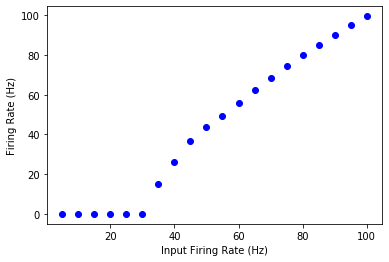

In [17]:
# iii.
# To get Hz out, divide the number of spikes by 2 for each time interval
Hz_out_list = [interval/2 for interval in Spikes_out_list]
plt.plot(Hz_in_list, Hz_out_list, 'bo')
plt.xlabel('Input Firing Rate (Hz)')
plt.ylabel('Firing Rate (Hz)');

## (b) Two LIF Neurons

In [18]:
# i.
net = SpikingNetwork()
in1 = InputNeuron( GenerateSpikeTrain([30, 0], [0.3, 2]) )  # Create an input neuron
A = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)  # LIF neuron A
B = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)  # LIF neuron B


net.AddNeuron(in1)  # Input neuron, Neuron 0 
net.AddNeuron(A)  # LIF neuron A, Neuron 1
net.AddNeuron(B)  # LIF neuron B, Neuron 2

net.Connect(in1.Get_idx(), A.Get_idx(), 0.05)  # Connection from neuron 0 to neuron 1
net.Connect(A.Get_idx(), B.Get_idx(), 0.05)  # Connection from neuron 1 to neuron 2
net.Connect(B.Get_idx(), A.Get_idx(), 0.05)  # Connection from neuron 2 to neuron 1


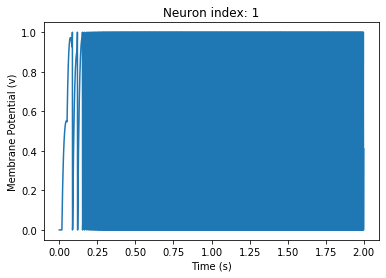

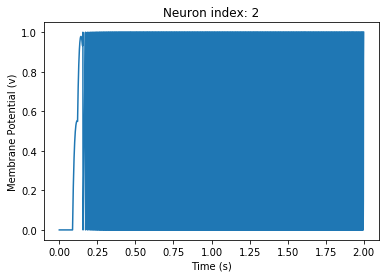

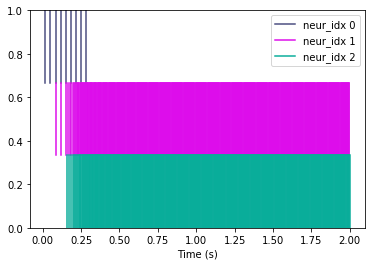

In [19]:
# ii.

net.Simulate(2, 0.001) # Simulate for 2 seconds

# Plot the membrane potential of all neurons in net
for neuron in net.neurons:
    if type(neuron) is InputNeuron:
        continue
    else:
        plt.plot(net.t_history, net.GetNeuron(neuron.Get_idx()).Get_v_history());
    plt.title("Neuron index: {0}".format(neuron.Get_idx()))
    plt.xlabel('Time (s)')
    plt.ylabel('Membrane Potential (v)');
    plt.show()


# Plot the spike rasters for all the neurons in the network.
PlotSpikeRaster( net.AllSpikeTimes() )
plt.show()

## (c) Three LIF Neurons: Inhibition

In [20]:
# i.
net = SpikingNetwork()
in1 = InputNeuron( GenerateSpikeTrain([30, 0], [0.3, 1.5]) )  # Input neuron 1
A = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)  # LIF neuron A
B = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)  # LIF neuron B
C = LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)  # LIF neuron C
in2 = InputNeuron( GenerateSpikeTrain([0, 50], [0.7, 1]) )  # Input neuron 2

net.AddNeuron(in1)  # Input neuron 1, Neuron 0 
net.AddNeuron(A)  # LIF neuron A, Neuron 1
net.AddNeuron(B)  # LIF neuron B, Neuron 2
net.AddNeuron(C)  # LIF neuron C, Neuron 3
net.AddNeuron(in2)  # Input neuron 2, Neuron 4 

net.Connect(in1.Get_idx(), A.Get_idx(), 0.05)  # Connection from neuron 0 to neuron 1
net.Connect(A.Get_idx(), B.Get_idx(), 0.05)  # Connection from neuron 1 to neuron 2
net.Connect(B.Get_idx(), A.Get_idx(), 0.05)  # Connection from neuron 2 to neuron 1
net.Connect(C.Get_idx(), B.Get_idx(), -0.2)  # Connection from neuron 3 to neuron 2
net.Connect(in2.Get_idx(), C.Get_idx(), 0.05)  # Connection from neuron 4 to neuron 3

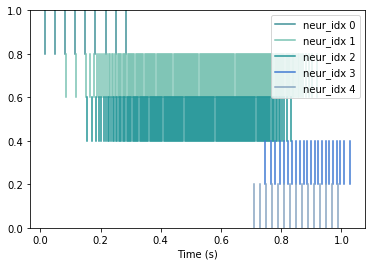

In [21]:
# ii.
net.Simulate(1.5, 0.001) # Simulate for 1.5 seconds

# Plot the spike rasters for all the neurons in the network.
PlotSpikeRaster( net.AllSpikeTimes() )
plt.show()

### iii.

The firing rates of neurons A and B started decreasing as input neuron 2 started sending spikes to neuron C at 0.7s,

The spikes from Input neuron 2 activated neuron C, which started sending spikes to neuron B, since the connection between neurons C and B was inhibitory, the firing rates of both neurons A and B started to decrease (eventually stopped at 1s).

## (d) Ring Oscillator

In [22]:
# i.
net = SpikingNetwork()

for neur in range(8):   # LIF neuron 0, 1, ..., 7
    net.AddNeuron(LIFNeuron(Tau_m=0.05, Tau_ref=0.002, Tau_s=0.1))

for ab in range(7):    
    net.Connect(ab, ab+1, 0.2)
net.Connect(7, 0, 0.2)


In [23]:
# ii.
for ba in range(7):
    net.Connect(ba+1, ba, -0.4)
net.Connect(0, 7, -0.4)

In [24]:
# iii.
in_neur = InputNeuron( GenerateSpikeTrain([25, 0], [0.3, 5]) )  # Input neuron, neuron 8
net.AddNeuron(in_neur)
net.Connect(8, 0, 0.2)

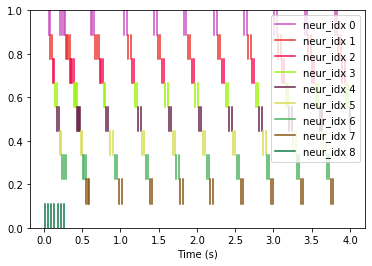

In [25]:
# iv.
net.Simulate(4, 0.001) # Simulate for 4 seconds

# Plot the spike rasters for all the neurons in the network.
PlotSpikeRaster( net.AllSpikeTimes() )
plt.show()

In [26]:
# v.
for lif_neur_idx in range(8):
    neur = net.GetNeuron(lif_neur_idx)
    spike_list = neur.Get_spikes()
    num_of_bursts = 0
    for spike_idx in range(len(spike_list)-1):
        if spike_list[spike_idx+1] - spike_list[spike_idx] > 0.1:
            num_of_bursts += 1
    print("Neuron {0}: In {1:.2f}s, it went through {2} bursts, average time per burst is {3:.2f}s."
          .format(lif_neur_idx, spike_list[-1]-spike_list[0], num_of_bursts,
                 (spike_list[-1]-spike_list[0])/num_of_bursts))

Neuron 0: In 3.77s, it went through 10 bursts, average time per burst is 0.38s.
Neuron 1: In 3.79s, it went through 10 bursts, average time per burst is 0.38s.
Neuron 2: In 3.81s, it went through 10 bursts, average time per burst is 0.38s.
Neuron 3: In 3.83s, it went through 10 bursts, average time per burst is 0.38s.
Neuron 4: In 3.82s, it went through 10 bursts, average time per burst is 0.38s.
Neuron 5: In 3.48s, it went through 9 bursts, average time per burst is 0.39s.
Neuron 6: In 3.49s, it went through 9 bursts, average time per burst is 0.39s.
Neuron 7: In 3.22s, it went through 8 bursts, average time per burst is 0.40s.


=== YOUR ANSWER HERE ===

It takes about 0.4s for the wave of activity to go around the ring.

# Q4: Neural Activation Functions

## (a) ReLU derivative

\begin{align}
f(x) &= ReLU(x) \\
&= max(0, x) \\
&= 
    \begin{cases}
        0 &\quad\text{if }x\le0\\
        x &\quad\text{if }x\ge0\\
    \end{cases} 
    \\
f'(x) &=
    \begin{cases}
        0 &\quad\text{if }x<0\\
        \text{Not differentiable} &\quad\text{if }x=0\\
        1 &\quad\text{if }x>0\\
    \end{cases} 
    \\
\end{align}


In [27]:
from sympy.interactive import printing
import sympy as sp
from sympy.utilities.lambdify import lambdify, implemented_function

printing.init_printing(use_latex=True)

## (b.i) Logistic

Standard logistic function:


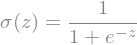

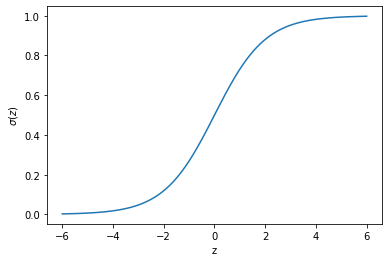

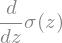

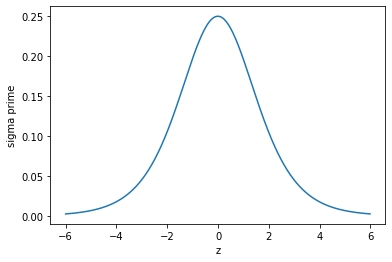

In [28]:
z = sp.symbols('z')
sigma_symbol = sp.Function('sigma')

def sigma_f(x):
    return 1/(1+sp.exp(-x))

print("Standard logistic function:")
display(sp.Eq(sigma_symbol(z), sigma_f(z)))

# Plot sigma
z_vals = np.linspace(-6, 6, 1000)
sigma_vals = np.array([sigma_f(zi) for zi in z_vals])
plt.plot(z_vals, sigma_vals)
plt.xlabel(z)
plt.ylabel('$\sigma(z)$')
plt.show()

# Plot sigma_prime
display(sigma_symbol(z).diff(z))
sigma_prime = np.array([(sigma_vals[i+1]-sigma_vals[i])/(z_vals[i+1]-z_vals[i]) 
                        for i in range(len(z_vals)-1)])
plt.plot(z_vals[:-1], sigma_prime)
plt.xlabel(z)
plt.ylabel("sigma prime")
plt.show()

## (b.ii) tanh

Hyperbolic tangent:


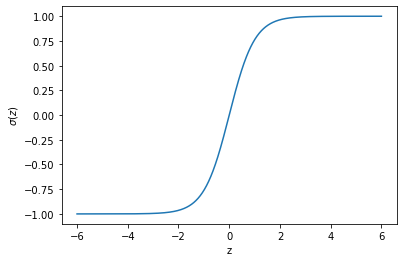

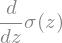

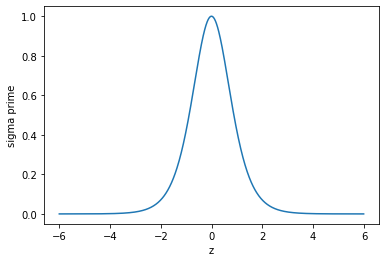

In [29]:
z = sp.symbols('z')
sigma_symbol = sp.Function('sigma')

def sigma_f(x):
    return sp.tanh(x)

print("Hyperbolic tangent:")
display(sp.Eq(sigma_symbol(z), sigma_f(z)))

# Plot sigma
z_vals = np.linspace(-6, 6, 1000)
sigma_vals = np.array([sigma_f(zi) for zi in z_vals])
plt.plot(z_vals, sigma_vals)
plt.xlabel(z)
plt.ylabel('$\sigma(z)$')
plt.show()

# Plot sigma_prime
display(sigma_symbol(z).diff(z))
sigma_prime = np.array([(sigma_vals[i+1]-sigma_vals[i])/(z_vals[i+1]-z_vals[i]) 
                        for i in range(len(z_vals)-1)])
plt.plot(z_vals[:-1], sigma_prime)
plt.xlabel(z)
plt.ylabel("sigma prime")
plt.show()

## (b.iii) ReLU

Rectified Linear Unit:


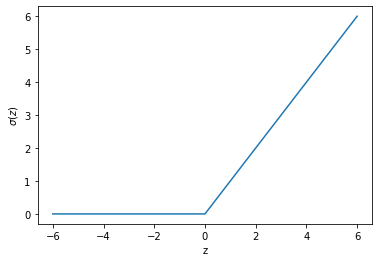

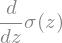

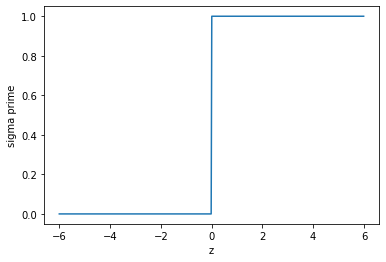

In [30]:
z = sp.symbols('z')
sigma_symbol = sp.Function('sigma')

def sigma_f(x):
    return sp.Max(0, x)

print("Rectified Linear Unit:")
display(sp.Eq(sigma_symbol(z), sigma_f(z)))

# Plot sigma
z_vals = np.linspace(-6, 6, 1000)
sigma_vals = np.array([sigma_f(zi) for zi in z_vals])
plt.plot(z_vals, sigma_vals)
plt.xlabel(z)
plt.ylabel('$\sigma(z)$')
plt.show()

# Plot sigma_prime
display(sigma_symbol(z).diff(z))
sigma_prime = np.array([(sigma_vals[i+1]-sigma_vals[i])/(z_vals[i+1]-z_vals[i]) 
                        for i in range(len(z_vals)-1)])
plt.plot(z_vals[:-1], sigma_prime)
plt.xlabel(z)
plt.ylabel("sigma prime")
plt.show()

## (c.i) Derivative of f with respect to x

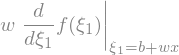

In [31]:
f = sp.Function('f')
w, x, b = sp.symbols('w x b')

expr = f(w*x+b)
display(sp.diff(expr, x))

\begin{align}
f(wx+b) &= f(z) \\
\frac{df}{dx} &= \frac{df}{dz}\frac{dz}{dx}  \\
&= \frac{df}{dz}w\\
\end{align}


## (c.ii) Derivative of f with respect to w

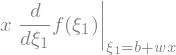

In [32]:
display(sp.diff(expr, w))

\begin{align}
f(wx+b) &= f(z) \\
\frac{df}{dw} &= \frac{df}{dz}\frac{dz}{dw}  \\
&= \frac{df}{dz}x\\
\end{align}


## (c.ii) Derivative of f with respect to b

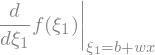

In [33]:
display(sp.diff(expr, b))

\begin{align}
f(wx+b) &= f(z) \\
\frac{df}{db} &= \frac{df}{dz}\frac{dz}{db}  \\
&= \frac{df}{dz}\\
\end{align}
